# 1. Import libraries and initialize Groq client ( LLM )

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from groq import Groq
import re
from datetime import datetime, timedelta

# Initialize Groq client (replace with your actual API key)
groq_client = Groq(api_key="YOUR_API_KEY")

# 2. Define Functions

## 2.1 - Get Top S&P 500 Stocks

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def get_top_sp500_stocks(n=20):
    # declare top 10 stocks in S&P 500
    tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'GOOG', 'META', 'TSLA', 'BRK.B', 'JPM', 'V']
    
    # Get market cap for each stock
    market_caps = {}
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        market_caps[ticker] = stock.info.get('marketCap', 0)
    
    # Sort by market cap and get top n
    top_stocks = sorted(market_caps.items(), key=lambda x: x[1], reverse=True)[:n]
    return [stock[0] for stock in top_stocks]

## 2.2 - Get Financial Data

In [ ]:
def get_financial_data(ticker, start_date, end_date):
    stock = yf.Ticker(ticker)
    
    # Get historical price data
    price_data = stock.history(start=start_date, end=end_date)
    
    # Get income statement
    income_statement = stock.financials
    
    return {
        "price_data": price_data,
        "income_statement": income_statement
    }

## 2.3 - Format Income Statement for LLM

In [ ]:
def format_income_statement_for_llm(income_statement_column):
    formatted_text = ""
    for index, value in income_statement_column.items():
        formatted_value = f"{value:,.2f}" if isinstance(value, (int, float)) else str(value)
        formatted_text += f"{index}: {formatted_value}\n"
    return formatted_text.strip()

## 2.4 - Create Prompt for Income Statement Evaluation

In [ ]:
def create_prompt_for_income_statement(current_year_income_statement, previous_year_income_statement):
    prompt = f"""
Evaluate the following income statements for the current year and the previous year. Provide a score between 0 and 10 for each criterion, where 0 is very poor and 10 is excellent. Consider criteria such as revenue growth, profitability, operating efficiency, and earnings quality. Additionally, provide an overall score based on the average of the criteria scores.

Income Statement for the Current Year:
{current_year_income_statement}

Income Statement for the Previous Year:
{previous_year_income_statement}

Criteria for Evaluation:
1. Revenue Growth: Analyze the growth in revenue compared to the previous year.
2. Gross Profit Margin: Calculate as Gross Profit / Total Revenue.
3. Operating Margin: Calculate as Operating Income / Total Revenue.
4. Net Profit Margin: Calculate as Net Income / Total Revenue.
5. EPS Growth: Compare EPS to the previous year.
6. Operating Efficiency: Consider Operating Expense relative to Total Revenue.
7. Interest Coverage Ratio: Calculate as EBIT / Interest Expense.

Provide the score for each criterion and an overall score. Include explanations for each score.
    """
    return prompt

## 2.5 - Evaluate Income Statements Using LLM


In [ ]:
def evaluate_income_statements_llm(current_year_income_statement, previous_year_income_statement):
    prompt = create_prompt_for_income_statement(current_year_income_statement, previous_year_income_statement)
    response = groq_client.chat.completions.create(
        messages=[{"role": "user", "content": prompt}],
        model="llama-3.1-8b-instant",
        temperature=0.2,
        max_tokens=1000
    )
    analysis = response.choices[0].message.content.strip()
    score = re.search(r"Overall Score: (\d+\.\d+)", analysis)
    return float(score.group(1)) if score else None

## 2.6 - Evaluate Stock

In [ ]:
def evaluate_stock(ticker, start_date, end_date):
    data = get_financial_data(ticker, start_date, end_date)
    income_statement = data['income_statement']
    
    scores = []
    for i in range(len(income_statement.columns) - 1):
        current_year = format_income_statement_for_llm(income_statement.iloc[:, i])
        previous_year = format_income_statement_for_llm(income_statement.iloc[:, i+1])
        score = evaluate_income_statements_llm(current_year, previous_year)
        scores.append((income_statement.columns[i].year, score))
    
    return pd.DataFrame(scores, columns=['Year', 'Score'])

## 2.7 - Backtest Strategy

In [97]:
import pandas as pd
import numpy as np
from tabulate import tabulate

def backtest_strategy(all_scores, price_data):
    portfolio_returns = []
    executed_trades = []
    
    for year in range(min(all_scores['Year']), max(all_scores['Year']) + 1):
        # Select top 3 stocks for the year with a score greater than 7
        top_stocks = all_scores[(all_scores['Year'] == year) & (all_scores['Score'] > 7)].nlargest(3, 'Score')['Ticker'].tolist()
        
        # Calculate returns for the selected stocks
        returns = []
        for stock in top_stocks:
            stock_prices = price_data[stock]
            start_price = stock_prices[stock_prices.index.year == year].iloc[0]['Close']
            end_price = stock_prices[stock_prices.index.year == year].iloc[-1]['Close']
            profit_loss = (end_price - start_price) / start_price
            returns.append(profit_loss)
            
            # Record the trade
            executed_trades.append({
                'Year': year,
                'Ticker': stock,
                'Start Price': start_price,
                'End Price': end_price,
                'Profit/Loss (%)': profit_loss * 100
            })
        
        # Calculate average return for the portfolio
        portfolio_return = np.mean(returns) if returns else 0  # Handle case where no stocks meet criteria
        portfolio_returns.append((year, portfolio_return))
    
    # Calculate cumulative returns
    cumulative_returns = pd.DataFrame(portfolio_returns, columns=['Year', 'Return'])
    cumulative_returns['Cumulative Return'] = (1 + cumulative_returns['Return']).cumprod() - 1
    
    return cumulative_returns, pd.DataFrame(executed_trades)

# 3. Main Execution

## 3.1 - Get and Save Top 20 Stocks

In [65]:
top_stocks = get_top_sp500_stocks(20)
pd.DataFrame(top_stocks, columns=['Ticker']).to_csv('top_20_stocks.csv', index=False)

# Read the saved stocks
top_stocks = pd.read_csv('top_20_stocks.csv')['Ticker'].tolist()
print("Top 20 stocks:", top_stocks)


Top 20 stocks: ['AAPL', 'MSFT', 'GOOG', 'GOOGL', 'AMZN', 'META', 'TSLA', 'JPM', 'V', 'BRK.B']


## 3.2 - Evaluate Income Statement Scores

In [66]:
start_date = datetime.now() - timedelta(days=5*365)
end_date = datetime.now()

all_scores = []
price_data = {}

for ticker in top_stocks:
    print(f"Evaluating {ticker}...")
    scores = evaluate_stock(ticker, start_date, end_date)
    scores['Ticker'] = ticker
    all_scores.append(scores)
    
    # Get price data for backtesting
    price_data[ticker] = get_financial_data(ticker, start_date, end_date)['price_data']

all_scores = pd.concat(all_scores)

Evaluating AAPL...
Evaluating MSFT...
Evaluating GOOG...
Evaluating GOOGL...
Evaluating AMZN...
Evaluating META...
Evaluating TSLA...
Evaluating JPM...
Evaluating V...
Evaluating BRK.B...


BRK.B: No timezone found, symbol may be delisted
BRK.B: No timezone found, symbol may be delisted
/var/folders/3h/k_7p78896dn6jjq56w5lrq6m0000gn/T/ipykernel_1749/23346134.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_scores = pd.concat(all_scores)


In [70]:
# save the scores into a csv file
all_scores.to_csv('all_scores.csv', index=False)

print(all_scores)

   Year  Score Ticker
0  2023   6.90   AAPL
1  2022   8.10   AAPL
2  2021   8.40   AAPL
0  2023   8.10   MSFT
1  2022   8.40   MSFT
2  2021   8.60   MSFT
0  2023   8.40   GOOG
1  2022   7.40   GOOG
2  2021   8.40   GOOG
3  2020    NaN   GOOG
0  2023    NaN  GOOGL
1  2022   7.90  GOOGL
2  2021   8.30  GOOGL
3  2020    NaN  GOOGL
0  2023   7.90   AMZN
1  2022   3.40   AMZN
2  2021   7.40   AMZN
3  2020    NaN   AMZN
0  2023   8.30   META
1  2022   6.70   META
2  2021   8.40   META
3  2020    NaN   META
0  2023   6.90   TSLA
1  2022   8.30   TSLA
2  2021   7.40   TSLA
3  2020   4.29   TSLA
0  2023    NaN    JPM
1  2022    NaN    JPM
2  2021    NaN    JPM
3  2020   6.14    JPM
0  2023   8.10      V
1  2022    NaN      V
2  2021   7.90      V
3  2020    NaN      V


## 3.3 - Save Results

In [71]:
import pandas as pd

# Assuming all_scores is already a DataFrame
# Pivot the table
pivoted_scores = all_scores.pivot(index='Year', columns='Ticker', values='Score')

# Sort the index (Year) in descending order to have the most recent year first
pivoted_scores = pivoted_scores.sort_index(ascending=False)

# Keep only the last 3 years
pivoted_scores = pivoted_scores.head(3)

# Reset the index to make 'Year' a regular column
pivoted_scores = pivoted_scores.reset_index()

# Save the pivoted DataFrame to a CSV file
pivoted_scores.to_csv('pivoted_stock_scores.csv', index=False)

print("Pivoted scores have been saved to 'pivoted_stock_scores.csv'")

# Display the pivoted DataFrame
print(pivoted_scores)

# Optionally, you can display info about the DataFrame to check its structure
print(pivoted_scores.info())

Pivoted scores have been saved to 'pivoted_stock_scores.csv'
Ticker  Year  AAPL  AMZN  GOOG  GOOGL  JPM  META  MSFT  TSLA    V
0       2023   6.9   7.9   8.4    NaN  NaN   8.3   8.1   6.9  8.1
1       2022   8.1   3.4   7.4    7.9  NaN   6.7   8.4   8.3  NaN
2       2021   8.4   7.4   8.4    8.3  NaN   8.4   8.6   7.4  7.9
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    3 non-null      int64  
 1   AAPL    3 non-null      float64
 2   AMZN    3 non-null      float64
 3   GOOG    3 non-null      float64
 4   GOOGL   2 non-null      float64
 5   JPM     0 non-null      float64
 6   META    3 non-null      float64
 7   MSFT    3 non-null      float64
 8   TSLA    3 non-null      float64
 9   V       2 non-null      float64
dtypes: float64(9), int64(1)
memory usage: 372.0 bytes
None


## 3.4 - Backtest Strategy

In [98]:
cumulative_returns, executed_trades = backtest_strategy(all_scores, price_data)

# Print the executed trades in a better format
print("Executed Trades:")
print(tabulate(executed_trades, headers='keys', tablefmt='pretty'))

# Print cumulative returns
print("\nCumulative Returns:")
print(tabulate(cumulative_returns, headers='keys', tablefmt='pretty'))

Executed Trades:
+---+------+--------+--------------------+--------------------+---------------------+
|   | Year | Ticker |    Start Price     |     End Price      |   Profit/Loss (%)   |
+---+------+--------+--------------------+--------------------+---------------------+
| 0 | 2021 |  MSFT  | 211.22430419921875 | 329.06622314453125 | 55.789943014402574  |
| 1 | 2021 |  AAPL  | 126.8301010131836  | 175.10281372070312 |  38.06092743117955  |
| 2 | 2021 |  GOOG  | 86.31378173828125  | 144.5150604248047  |  67.42987911594474  |
| 3 | 2022 |  MSFT  | 327.5300598144531  | 236.84625244140625 | -27.687170888809277 |
| 4 | 2022 |  TSLA  | 399.9266662597656  | 123.18000030517578 | -69.19935310711031  |
| 5 | 2022 |  AAPL  | 179.48110961914062 | 128.86831665039062 | -28.199509728990684 |
| 6 | 2023 |  GOOG  | 89.59803771972656  | 140.76980590820312 |  57.11259921623285  |
| 7 | 2023 |  META  | 124.48419189453125 |  353.234130859375  |  183.7582230189125  |
| 8 | 2023 |  MSFT  | 236.60922241210

## 3.5 - Plot Results

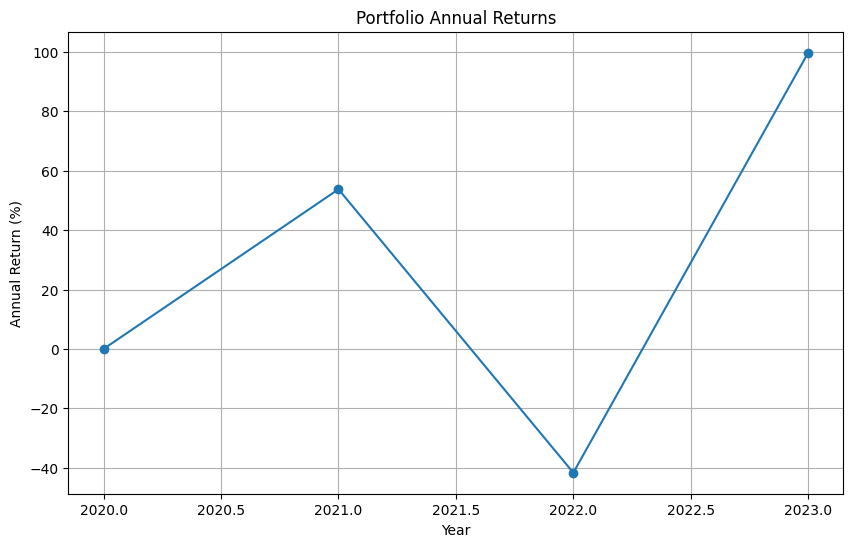

In [99]:
def plot_portfolio_returns_in_decimal(backtest_results):
    plt.figure(figsize=(12, 6))
    plt.plot(backtest_results['Year'], backtest_results['Return'], marker='o')
    plt.title('Portfolio Annual Returns')
    plt.xlabel('Year')
    plt.ylabel('Return')
    plt.grid(True)
    plt.savefig('portfolio_returns.png')
    plt.show() 

def plot_portfolio_annual_returns(portfolio_returns):
    # Rename 'Return' to 'Annual Return' and convert to percentages
    portfolio_returns = portfolio_returns.rename(columns={'Return': 'Annual Return'})
    portfolio_returns['Annual Return'] = portfolio_returns['Annual Return'] * 100
    
    plt.figure(figsize=(10, 6))
    plt.plot(portfolio_returns['Year'], portfolio_returns['Annual Return'], marker='o')
    plt.title('Portfolio Annual Returns')
    plt.xlabel('Year')
    plt.ylabel('Annual Return (%)')
    plt.grid(True)
    plt.show()

# Assuming backtest_results is the DataFrame with the backtest results
plot_portfolio_annual_returns(backtest_results)

## 3.6 - Calculate and Print Metrics

In [100]:
total_return = (backtest_results['Return'] + 1).prod() - 1
annual_return = (1 + total_return) ** (1 / len(backtest_results)) - 1
sharpe_ratio = np.mean(backtest_results['Return']) / np.std(backtest_results['Return'])

print(f"Total Return: {total_return:.2%}")
print(f"Annual Return: {annual_return:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Total Return: 79.07%
Annual Return: 15.68%
Sharpe Ratio: 0.52


## 3.7 - Save Backtest Results

In [101]:
backtest_results.to_csv('backtest_results.csv', index=False)
print("Backtest results saved to 'backtest_results.csv'")

Backtest results saved to 'backtest_results.csv'
